# Networks Project


In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import Counter

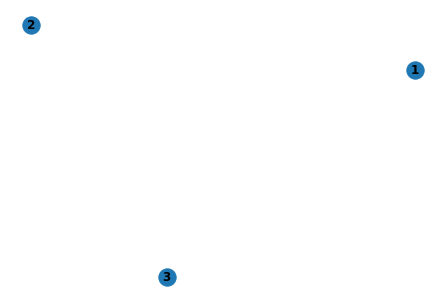

In [23]:
G = nx.Graph()

#G.add_node(1)
#H = nx.path_graph(10)
#G.add_nodes_from(H)
G.add_nodes_from([1,2,3])

G.add_edge(1,1)
#G.add_edges_from([(2,1),(1,3)])

nx.draw(G, with_labels=True, font_weight='bold')

## Barabasi-Albert Model

Add exception error to prevent m > m0

Used a preferential list. Makes a list of of the every edge connection to a vertex. Having a larger number of these causes it to have a higher probability across the whole list. 

In [17]:
class BA():
    
    def __init__(self,time_limit,m,m_start):
        """
        time_limit: run time until this value
        m: number edges to add every time a new vertex is added
        m0: int, set up initial graph. 
        """
        G0 = nx.Graph()
        m_start = [x+1 for x in range(m_start)]
                
        G0.add_nodes_from(m_start)
        G0.add_edges_from([(x+1,x+2) for x in range(len(m_start)-1)])
        t = 0
        
        self.m = m
        self.G = G0
        self.preferential_list = m_start
        self.time_limit = time_limit
        
        if self.m > len(m_start):
            raise ValueError("m value must be less than initial graph value")
    
    def run(self):
        for t in range(1,self.time_limit + 1):
            node = t + 2 #Find the node number
            
            connections = []
            for i in range(self.m):
                edge = random.choice(self.preferential_list)
                while edge in connections:
                    edge = random.choice(self.preferential_list)
                connections.append(edge)
            
            edges = [(node,x) for x in (connections)]
            
            # Extend list of preferentials with the the vertices, both to and from 
            [self.preferential_list.extend(e) for e in edges]

            self.G.add_node(node)
            self.G.add_edges_from(edges)
            
    def get_degrees(self):
        return self.preferential_list
    
    def draw(self):
        nx.draw(self.G, with_labels=True, font_weight='bold')

In [18]:
time = 100000

Ba = BA(time_limit = time,m = 1,m_start = 2)
Ba.run()
# Ba.draw()
prefs = Ba.get_degrees()


# plt.figure()
# # plt.hist(prefs,bins = time+1)
# plt.hist(prefs,bins = int((time+1)/3))
# print("checks")


Now check your programme is working correctly. This is very important. You need to explain in your report why you think your numerical results are correct.